<a href="https://colab.research.google.com/github/akbar19950210/notebook/blob/main/CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
!pip install torch torchvision
import torch  # 现在应该能正常导入
print(torch.__version__)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 102.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 81.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 55.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 88.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [19]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import random
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

# 步骤1：数据集准备与配对

In [20]:
class_names = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# 定义3个超类分组
groups = [
    {'plane', 'ship'},      # 交通工具-天空/海洋
    {'car', 'truck'},       # 交通工具-地面
    {'bird', 'cat', 'deer', 'dog', 'frog', 'horse'}  # 动物
]

def get_superclass_label(class_name):
    """获取图片的超类标签(0/1/2)"""
    for idx, group in enumerate(groups):
        if class_name in group:
            return idx
    raise ValueError(f"无效类别: {class_name}")

def get_pair_label(class_name1, class_name2):
    """判断两张图片是否属于同一超类(返回1/0)"""
    return int(get_superclass_label(class_name1) == get_superclass_label(class_name2))

class PairedCIFAR10(Dataset):
    def __init__(self, base_dataset, num_pairs=10000, transform=None):
        """
        配对CIFAR-10数据集
        Args:
            base_dataset: 原始CIFAR-10数据集
            num_pairs: 要生成的图片对数 (自动限制不超过数据集容量)
            transform: 数据增强变换
        """
        self.base_dataset = base_dataset
        self.transform = transform
        self.num_pairs = min(num_pairs, len(base_dataset) // 2)  # 自动限制最大可能对数
        self.pairs = []

        # 生成所有可能的索引并打乱
        indices = list(range(len(base_dataset)))
        random.shuffle(indices)

        # 生成图片对
        for i in range(0, self.num_pairs * 2, 2):
            idx1, idx2 = indices[i], indices[i+1]
            img1, label1 = base_dataset[idx1]
            img2, label2 = base_dataset[idx2]

            # 获取类别名称和配对标签
            name1 = class_names[label1]
            name2 = class_names[label2]
            label = get_pair_label(name1, name2)

            # 水平拼接图片 (32x32 -> 64x32)
            paired_img = Image.new('RGB', (64, 32))
            paired_img.paste(img1, (0, 0))
            paired_img.paste(img2, (32, 0))

            self.pairs.append((paired_img, label))

    def __len__(self):
        return self.num_pairs

    def __getitem__(self, idx):
        img, label = self.pairs[idx]
        if self.transform:
            img = self.transform(img)
        return img, torch.tensor(label, dtype=torch.long)


# 步骤2：模型架构

In [21]:
class FlexibleCNN(nn.Module):
    def __init__(self, out_features=2):
        """
        可处理拼接图片的CNN
        Args:
            out_features: 输出维度 (2 for 二分类)
        """
        super().__init__()
        self.features = nn.Sequential(
            # 输入: 3x32x64 (拼接后的图片)
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),  # -> 32x16x32

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),  # -> 64x8x16

            nn.AdaptiveAvgPool2d((4, 4))  # -> 64x4x4
        )

        self.classifier = nn.Sequential(
            nn.Linear(64*4*4, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, out_features)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # 展平
        return self.classifier(x)

# 步骤3：训练与评估

In [22]:
def train_epoch(model, loader, optimizer, criterion, device):
    """训练一个epoch"""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in tqdm(loader, desc="Training"):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    return running_loss/len(loader), correct/total

def evaluate(model, loader, criterion, device):
    """评估模型性能"""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in tqdm(loader, desc="Evaluating"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    return running_loss/len(loader), correct/total


# 4：主流程

使用设备: cpu
加载CIFAR-10数据集...
生成配对数据集...


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(



开始训练...

Epoch 1/15


Evaluating: 100%|██████████| 40/40 [00:08<00:00,  4.89it/s]


训练 Loss: 0.5254 | Acc: 0.7464
验证 Loss: 0.4493 | Acc: 0.7972

Epoch 2/15


Evaluating: 100%|██████████| 40/40 [00:15<00:00,  2.63it/s]


训练 Loss: 0.4534 | Acc: 0.7928
验证 Loss: 0.4199 | Acc: 0.8094

Epoch 3/15


Evaluating: 100%|██████████| 40/40 [00:10<00:00,  3.80it/s]


训练 Loss: 0.4232 | Acc: 0.8050
验证 Loss: 0.3789 | Acc: 0.8274

Epoch 4/15


Evaluating: 100%|██████████| 40/40 [00:09<00:00,  4.26it/s]


训练 Loss: 0.4138 | Acc: 0.8092
验证 Loss: 0.4141 | Acc: 0.8154

Epoch 5/15


Evaluating: 100%|██████████| 40/40 [00:10<00:00,  3.70it/s]


训练 Loss: 0.4031 | Acc: 0.8131
验证 Loss: 0.3608 | Acc: 0.8340

Epoch 6/15


Evaluating: 100%|██████████| 40/40 [00:10<00:00,  3.83it/s]


训练 Loss: 0.3920 | Acc: 0.8207
验证 Loss: 0.3462 | Acc: 0.8382

Epoch 7/15


Evaluating: 100%|██████████| 40/40 [00:10<00:00,  3.76it/s]


训练 Loss: 0.3878 | Acc: 0.8187
验证 Loss: 0.3475 | Acc: 0.8382

Epoch 8/15


Evaluating: 100%|██████████| 40/40 [00:09<00:00,  4.38it/s]


训练 Loss: 0.3810 | Acc: 0.8243
验证 Loss: 0.3390 | Acc: 0.8444

Epoch 9/15


Evaluating: 100%|██████████| 40/40 [00:10<00:00,  3.70it/s]


训练 Loss: 0.3697 | Acc: 0.8288
验证 Loss: 0.3991 | Acc: 0.7974

Epoch 10/15


Evaluating: 100%|██████████| 40/40 [00:10<00:00,  3.80it/s]


训练 Loss: 0.3667 | Acc: 0.8323
验证 Loss: 0.3711 | Acc: 0.8300

Epoch 11/15


Evaluating: 100%|██████████| 40/40 [00:10<00:00,  3.73it/s]


训练 Loss: 0.3647 | Acc: 0.8316
验证 Loss: 0.3385 | Acc: 0.8468

Epoch 12/15


Evaluating: 100%|██████████| 40/40 [00:09<00:00,  4.23it/s]


训练 Loss: 0.3617 | Acc: 0.8328
验证 Loss: 0.3343 | Acc: 0.8438

Epoch 13/15


Evaluating: 100%|██████████| 40/40 [00:10<00:00,  3.65it/s]


训练 Loss: 0.3502 | Acc: 0.8386
验证 Loss: 0.3458 | Acc: 0.8388

Epoch 14/15


Evaluating: 100%|██████████| 40/40 [00:10<00:00,  3.89it/s]


训练 Loss: 0.3505 | Acc: 0.8396
验证 Loss: 0.3375 | Acc: 0.8442

Epoch 15/15


Evaluating: 100%|██████████| 40/40 [00:09<00:00,  4.02it/s]
<ipython-input-23-ebc181ec1947>:76: UserWarning: Glyph 25439 (\N{CJK UNIFIED IDEOGRAPH-635F}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-23-ebc181ec1947>:76: UserWarning: Glyph 22833 (\N{CJK UNIFIED IDEOGRAPH-5931}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-23-ebc181ec1947>:76: UserWarning: Glyph 26354 (\N{CJK UNIFIED IDEOGRAPH-66F2}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-23-ebc181ec1947>:76: UserWarning: Glyph 32447 (\N{CJK UNIFIED IDEOGRAPH-7EBF}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-23-ebc181ec1947>:76: UserWarning: Glyph 35757 (\N{CJK UNIFIED IDEOGRAPH-8BAD}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-23-ebc181ec1947>:76: UserWarning: Glyph 32451 (\N{CJK UNIFIED IDEOGRAPH-7EC3}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-23-ebc181ec1947>:76: UserWarnin

训练 Loss: 0.3471 | Acc: 0.8417
验证 Loss: 0.3095 | Acc: 0.8578


<ipython-input-23-ebc181ec1947>:76: UserWarning: Glyph 20934 (\N{CJK UNIFIED IDEOGRAPH-51C6}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-23-ebc181ec1947>:76: UserWarning: Glyph 30830 (\N{CJK UNIFIED IDEOGRAPH-786E}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-23-ebc181ec1947>:76: UserWarning: Glyph 29575 (\N{CJK UNIFIED IDEOGRAPH-7387}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-23-ebc181ec1947>:77: UserWarning: Glyph 25439 (\N{CJK UNIFIED IDEOGRAPH-635F}) missing from font(s) DejaVu Sans.
  plt.savefig('training_results.png', dpi=300)
<ipython-input-23-ebc181ec1947>:77: UserWarning: Glyph 22833 (\N{CJK UNIFIED IDEOGRAPH-5931}) missing from font(s) DejaVu Sans.
  plt.savefig('training_results.png', dpi=300)
<ipython-input-23-ebc181ec1947>:77: UserWarning: Glyph 26354 (\N{CJK UNIFIED IDEOGRAPH-66F2}) missing from font(s) DejaVu Sans.
  plt.savefig('training_results.png', dpi=300)
<ipython-input-23-ebc181ec19

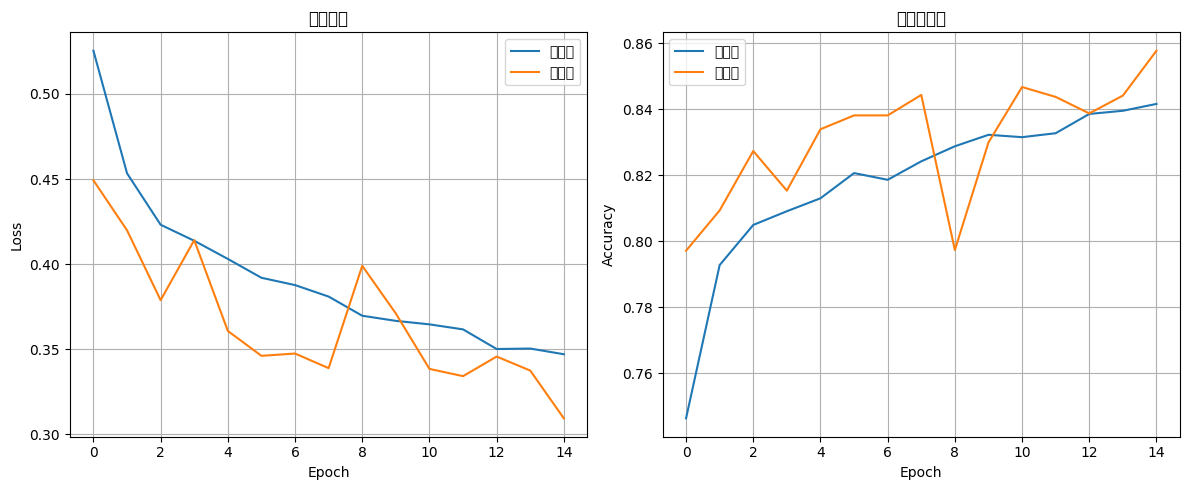

In [23]:
def main():
    # 配置
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"使用设备: {device}")

    # 数据增强
    transform_train = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    # 加载原始数据集
    print("加载CIFAR-10数据集...")
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True)
    testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True)

    # 创建配对数据集
    print("生成配对数据集...")
    paired_trainset = PairedCIFAR10(trainset, num_pairs=25000, transform=transform_train)
    paired_testset = PairedCIFAR10(testset, num_pairs=5000, transform=transform_test)

    train_loader = DataLoader(paired_trainset, batch_size=128, shuffle=True, num_workers=4)
    test_loader = DataLoader(paired_testset, batch_size=128, shuffle=False, num_workers=4)

    # 初始化模型
    model = FlexibleCNN(out_features=2).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

    # 训练循环
    print("\n开始训练...")
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    for epoch in range(15):  # 训练15个epoch
        print(f"\nEpoch {epoch+1}/15")
        train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion, device)
        val_loss, val_acc = evaluate(model, test_loader, criterion, device)

        # 记录历史数据
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        print(f"训练 Loss: {train_loss:.4f} | Acc: {train_acc:.4f}")
        print(f"验证 Loss: {val_loss:.4f} | Acc: {val_acc:.4f}")

    # 可视化结果
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='训练集')
    plt.plot(history['val_loss'], label='验证集')
    plt.title('损失曲线')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='训练集')
    plt.plot(history['val_acc'], label='验证集')
    plt.title('准确率曲线')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.savefig('training_results.png', dpi=300)
    plt.show()

if __name__ == "__main__":
    main()